In [1]:
import csv
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import ipywidgets
from IPython import display

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
if not os.path.exists('./horse2zebra'):
  import gdown
  url = 'https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg'
  gdown.download(url, './horse2zebra.zip', quiet=False)
  !unzip ./horse2zebra.zip > /dev/null
  !rm horse2zebra.zip

Downloading...
From: https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg
To: /content/horse2zebra.zip
117MB [00:00, 160MB/s] 


In [4]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [5]:
import torchvision.transforms.functional as TF

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, state, path='horse2zebra/', inception=False):
        self.images_A = sorted(glob.glob(os.path.join(path, state, "A", "*.jpg")))
        self.images_B = sorted(glob.glob(os.path.join(path, state, "B", "*.jpg")))
        self.inception = inception

    def _transform(self, imageA, imageB):
        # Transform to RGB 
        if imageA.mode != 'RGB':
            imageA = imageA.convert('RGB')
        if imageB.mode != 'RGB':
            imageB = imageB.convert('RGB')

        # Resize
        ImageA = TF.resize(imageA, 128)
        ImageB = TF.resize(imageB, 128)

        # Transform to tensor
        imageA = TF.to_tensor(imageA)
        imageB = TF.to_tensor(imageB)

        # Normalize
        if self.inception:
            imageA = TF.normalize(imageA, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            imageB = TF.normalize(imageB, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        else:
            imageA = TF.normalize(imageA, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            imageB = TF.normalize(imageB, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        

        return imageA, imageB

    def __len__(self):
        return min(len(self.images_A), len(self.images_B))

    def __getitem__(self, idx):
        img_A = Image.open(self.images_A[idx])
        img_B = Image.open(self.images_B[idx])
        img_A, img_B = self._transform(img_A, img_B)
        return img_A, img_B

In [6]:
batch_size = 1
trainset = ImageDataset(state="train")
trainset_i = ImageDataset(state="train", inception=True)
print("Number of training samples are", len(trainset))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
train_loader_i = DataLoader(trainset_i, batch_size=batch_size, shuffle=True, num_workers=3)

testset = ImageDataset(state="test")
testset_i = ImageDataset(state="test", inception=True)
print("Number of test samples are", len(testset))
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
test_loader_i = DataLoader(testset_i, batch_size=batch_size, shuffle=False, num_workers=3)

Number of training samples are 1067
Number of test samples are 120


In [7]:
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1),
                                  nn.InstanceNorm2d(f),
                                  nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = nn.InstanceNorm2d(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x) + x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=6):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), nn.InstanceNorm2d(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), nn.InstanceNorm2d(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), nn.InstanceNorm2d(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), nn.InstanceNorm2d(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), nn.InstanceNorm2d(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers) # -> 256*256
        
    def forward(self, x):
        return self.conv(x)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, f=64):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = f, kernel_size = 4, stride = 2, padding = 1), # -> 128x128
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels = f, out_channels = f*2, kernel_size = 4, stride = 2, padding = 1), # -> 64x64
            nn.InstanceNorm2d(f*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels = f*2, out_channels = f*4, kernel_size = 4, stride = 2, padding = 1), # -> 32x32
            nn.InstanceNorm2d(f*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels = f*4, out_channels = f*8, kernel_size = 4, stride = 1, padding = 1), # -> 31x31
            nn.InstanceNorm2d(f*8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels = f*8, out_channels = 1, kernel_size = 4, stride = 1, padding = 1), # -> 30x30
            )
    def forward(self, x):
        return self.conv(x)

In [9]:
# Loss functions
def gan_true_loss(x):
    return torch.mean((x - 1)**2)

def gan_false_loss(x):
    return torch.mean(x**2)

def cyclic_loss(x_fake, x_real):
    return torch.mean(torch.abs(x_real - x_fake))

def identity_loss(x_fake, x_real):
    return torch.mean(torch.abs(x_real - x_fake))

def van_d_gan_loss(x_fake, x_real):
    return -torch.mean(F.logsigmoid(x_real) + F.logsigmoid(1-x_fake))

def van_g_gan_loss(x_fake):
    return -torch.mean(F.logsigmoid(x_fake))

In [10]:
def train(d_h, d_z, g_h2z, g_z2h, d_opt, g_opt, num_epochs=10):

    out_dict = {'d_h_gan_true_loss': [],
                'd_h_gan_false_loss': [],
                'd_z_gan_true_loss': [],
                'd_z_gan_false_loss': [],
                'd_h_loss': [],
                'd_z_loss': [],
                'd_loss': [],
                'g_h2z_gan_true_loss': [],
                'g_h2z_cyclic_loss': [],
                'g_h2z_identity_loss': [],
                'g_z2h_gan_true_loss': [],
                'g_z2h_cyclic_loss': [],
                'g_z2h_identity_loss': [],
                'g_h2z_loss': [],
                'g_z2h_loss': [],
                'g_loss': [],
                }

    for epoch in tqdm(range(num_epochs), unit='epoch'):

        arr_d_h_gan_true_loss = []
        arr_d_h_gan_false_loss = []
        arr_d_z_gan_true_loss = []
        arr_d_z_gan_false_loss = []
        arr_d_h_loss = []
        arr_d_z_loss = []
        arr_d_loss = []
        arr_g_h2z_gan_true_loss = []
        arr_g_h2z_cyclic_loss = []
        arr_g_h2z_identity_loss = []
        arr_g_z2h_gan_true_loss = []
        arr_g_z2h_cyclic_loss = []
        arr_g_z2h_identity_loss = []
        arr_g_h2z_loss = []
        arr_g_z2h_loss = []
        arr_g_loss = []

        for minibatch_no, (horse, zebra) in tqdm(enumerate(train_loader), total=len(train_loader)):
            horse = horse.to(device)
            zebra = zebra.to(device)

            # Create fake images through generators
            z_fake = g_h2z(horse) # horse to fake zebra
            h_fake = g_z2h(zebra) # zebra to fake horse
            h_rec = g_z2h(z_fake) # fake zebra to recovered horse
            z_rec = g_h2z(h_fake) # fake horse to recovered zebra
            
            # Clean optimizer gradients
            d_opt.zero_grad()

            # D_H > GAN losses
            h_fake_detached = h_fake.detach()
            d_h_gan_true_loss = gan_true_loss(d_h(horse))
            d_h_gan_false_loss = gan_false_loss(d_h(h_fake_detached))

            # D_Z > GAN losses
            z_fake_detached = z_fake.detach()
            d_z_gan_true_loss = gan_true_loss(d_z(zebra))
            d_z_gan_false_loss = gan_false_loss(d_z(z_fake_detached))

            # D_H and D_Z losses
            d_h_loss = (d_h_gan_true_loss + d_h_gan_false_loss) * 0.5
            d_z_loss = (d_z_gan_true_loss + d_z_gan_false_loss) * 0.5
            d_loss = d_h_loss + d_z_loss

            # Backpropagation
            d_loss.backward()
            d_opt.step()
            
            # Clean optimizer gradients
            g_opt.zero_grad()

            # G_H2Z > GAN, cyclic, and identity loss
            g_h2z_gan_true_loss = gan_true_loss(d_z(z_fake))
            g_h2z_cyclic_loss = 10 * cyclic_loss(h_rec, horse)
            g_h2z_identity_loss = 5 * identity_loss(g_z2h(horse), horse)

            # G_Z2H >  GAN, cyclic, and identity loss
            g_z2h_gan_true_loss = gan_true_loss(d_h(h_fake))
            g_z2h_cyclic_loss = 10 * cyclic_loss(z_rec, zebra)
            g_z2h_identity_loss = 5 * identity_loss(g_h2z(zebra), zebra)

            # G_H2Z and G_Z2H losses
            g_h2z_loss = g_h2z_gan_true_loss + g_h2z_cyclic_loss + g_h2z_identity_loss
            g_z2h_loss = g_z2h_gan_true_loss + g_z2h_cyclic_loss + g_z2h_identity_loss
            g_loss = g_h2z_loss + g_z2h_loss

            # Backpropagation
            g_loss.backward()
            g_opt.step()

            arr_d_h_gan_true_loss.append(d_h_gan_true_loss.cpu().item())
            arr_d_h_gan_false_loss.append(d_h_gan_false_loss.cpu().item())
            arr_d_z_gan_true_loss.append(d_z_gan_true_loss.cpu().item())
            arr_d_z_gan_false_loss.append(d_z_gan_false_loss.cpu().item())
            arr_d_h_loss.append(d_h_loss.cpu().item())
            arr_d_z_loss.append(d_z_loss.cpu().item())
            arr_d_loss.append(d_loss.cpu().item())
            arr_g_h2z_gan_true_loss.append(g_h2z_gan_true_loss.cpu().item())
            arr_g_h2z_cyclic_loss.append(g_h2z_cyclic_loss.cpu().item())
            arr_g_h2z_identity_loss.append(g_h2z_identity_loss.cpu().item())
            arr_g_z2h_gan_true_loss.append(g_z2h_gan_true_loss.cpu().item())
            arr_g_z2h_cyclic_loss.append(g_z2h_cyclic_loss.cpu().item())
            arr_g_z2h_identity_loss.append(g_z2h_identity_loss.cpu().item())
            arr_g_h2z_loss.append(g_h2z_loss.cpu().item())
            arr_g_z2h_loss.append(g_z2h_loss.cpu().item())
            arr_g_loss.append(g_loss.cpu().item())

        out_dict['d_h_gan_true_loss'].append(np.mean(arr_d_h_gan_true_loss))
        out_dict['d_h_gan_false_loss'].append(np.mean(arr_d_h_gan_false_loss))
        out_dict['d_z_gan_true_loss'].append(np.mean(arr_d_z_gan_true_loss))
        out_dict['d_z_gan_false_loss'].append(np.mean(arr_d_z_gan_false_loss))
        out_dict['d_h_loss'].append(np.mean(arr_d_h_loss))
        out_dict['d_z_loss'].append(np.mean(arr_d_z_loss))
        out_dict['d_loss'].append(np.mean(arr_d_loss))
        out_dict['g_h2z_gan_true_loss'].append(np.mean(arr_g_h2z_gan_true_loss))
        out_dict['g_h2z_cyclic_loss'].append(np.mean(arr_g_h2z_cyclic_loss))
        out_dict['g_h2z_identity_loss'].append(np.mean(arr_g_h2z_identity_loss))
        out_dict['g_z2h_gan_true_loss'].append(np.mean(arr_g_z2h_gan_true_loss))
        out_dict['g_z2h_cyclic_loss'].append(np.mean(arr_g_z2h_cyclic_loss))
        out_dict['g_z2h_identity_loss'].append(np.mean(arr_g_z2h_identity_loss))
        out_dict['g_h2z_loss'].append(np.mean(arr_g_h2z_loss))
        out_dict['g_z2h_loss'].append(np.mean(arr_g_z2h_loss))
        out_dict['g_loss'].append(np.mean(arr_g_loss))
    
    return out_dict

In [51]:
torch.cuda.empty_cache()

In [38]:
#Initialize networks
d_h = Discriminator().to(device)
d_z = Discriminator().to(device)
g_h2z = Generator().to(device)
g_z2h = Generator().to(device)
d_params = list(d_h.parameters()) + list(d_z.parameters())
g_params = list(g_h2z.parameters()) + list(g_z2h.parameters())
d_opt = torch.optim.Adam(d_params, 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g_params, 0.0001, (0.5, 0.999))

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, 0, 0.02)
    if isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0, 0.02)
d_h.apply(init_weights)
d_z.apply(init_weights)
g_h2z.apply(init_weights)
g_z2h.apply(init_weights)

In [ ]:
out_dict = train(d_h, d_z, g_h2z, g_z2h, d_opt, g_opt, num_epochs=10)

Export model

In [ ]:
# Save weights to csv and to google drive
for name, model in zip(['d_h', 'd_z', 'g_h2z', 'g_z2h'], [d_h, d_z, g_h2z, g_z2h]):
    torch.save(model.state_dict(), f'/content/gdrive/My Drive/Colab Notebooks/{name}')

In [ ]:
# Save out_dict to csv
with open('out_dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in out_dict.items():
       writer.writerow([key, value])

In [ ]:
# Move dictionary to google drive
!mv out_dict.csv /content/gdrive/My\ Drive/Colab\ Notebooks/

Load pretrained model

In [11]:
#Initialize networks
d_h = Discriminator().to(device)
d_z = Discriminator().to(device)
g_h2z = Generator().to(device)
g_z2h = Generator().to(device)
d_params = list(d_h.parameters()) + list(d_z.parameters())
g_params = list(g_h2z.parameters()) + list(g_z2h.parameters())
d_opt = torch.optim.Adam(d_params, 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g_params, 0.0001, (0.5, 0.999))

In [16]:
# Copy out_dict from google drive to content
# !cp /content/gdrive/My\ Drive/Colab\ Notebooks/out_dict.csv /content
# !cp /content/gdrive/My\ Drive/Colab\ Notebooks/out_dict2.csv /content
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/out_dict3.csv /content

In [17]:
# Transform csv to dictionary
# with open('out_dict.csv', mode='r') as infile:
#     reader = csv.reader(infile)
#     out_dict = {rows[0]:rows[1] for rows in reader}
# with open('out_dict2.csv', mode='r') as infile:
#     reader = csv.reader(infile)
#     out_dict2 = {rows[0]:rows[1] for rows in reader}
with open('out_dict3.csv', mode='r') as infile:
    reader = csv.reader(infile)
    out_dict3 = {rows[0]:rows[1] for rows in reader}

In [18]:
import ast
# Transform strings to lists
# for key, item in out_dict.items():
#     out_dict[key] = ast.literal_eval(item)
# for key, item in out_dict2.items():
#     out_dict2[key] = ast.literal_eval(item)
for key, item in out_dict3.items():
    out_dict3[key] = ast.literal_eval(item)

In [19]:
# Load model's weights
# for name, model in zip(['d_h', 'd_z', 'g_h2z', 'g_z2h'], [d_h, d_z, g_h2z, g_z2h]):
#     model.load_state_dict(torch.load(f'/content/gdrive/My Drive/Colab Notebooks/{name}'))
# for name, model in zip(['d_h2', 'd_z2', 'g_h2z2', 'g_z2h2'], [d_h, d_z, g_h2z, g_z2h]):
#     model.load_state_dict(torch.load(f'/content/gdrive/My Drive/Colab Notebooks/{name}'))
for name, model in zip(['d_h3', 'd_z3', 'g_h2z3', 'g_z2h3'], [d_h, d_z, g_h2z, g_z2h]):
    model.load_state_dict(torch.load(f'/content/gdrive/My Drive/Colab Notebooks/{name}'))

Plotting and FID

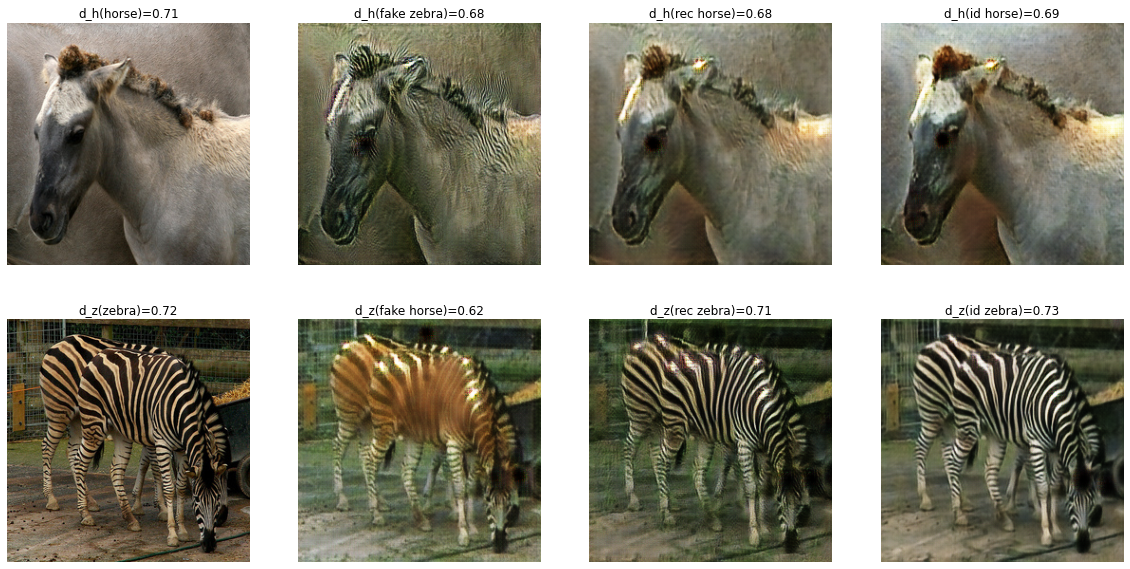

In [43]:
# Plot
plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 4, k+1) for k in range(8)]
P = torch.sigmoid

horse, zebra = next(iter(train_loader))
horse = horse.to(device)
zebra = zebra.to(device)

# Create fake images through generators
z_fake = g_h2z(horse) # horse to fake zebra
h_fake = g_z2h(zebra) # zebra to fake horse
h_rec = g_z2h(z_fake) # fake zebra to recovered horse
z_rec = g_h2z(h_fake) # fake horse to recovered zebra
h_id = g_z2h(horse) # horse to identity horse
z_id = g_h2z(zebra) # zebra to identity zebra

with torch.no_grad():
    subplots[0].imshow(horse.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
    subplots[1].imshow(z_fake.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
    subplots[2].imshow(h_rec.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
    subplots[3].imshow(h_id.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
    subplots[4].imshow(zebra.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
    subplots[5].imshow(h_fake.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
    subplots[6].imshow(z_rec.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
    subplots[7].imshow(z_id.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
    # Plot recovered image 
    subplots[0].set_title('d_h(horse)=%.2f' % P(d_h(horse)).max().cpu().item())
    subplots[1].set_title('d_h(fake zebra)=%.2f' % P(d_h(z_fake)).max().cpu().item())
    subplots[2].set_title('d_h(rec horse)=%.2f' % P(d_h(h_rec)).max().cpu().item())
    subplots[3].set_title('d_h(id horse)=%.2f' % P(d_h(h_id)).max().cpu().item())
    subplots[4].set_title('d_z(zebra)=%.2f' % P(d_z(zebra)).max().cpu().item())
    subplots[5].set_title('d_z(fake horse)=%.2f' % P(d_z(h_fake)).max().cpu().item())
    subplots[6].set_title('d_z(rec zebra)=%.2f' % P(d_z(z_rec)).max().cpu().item())
    subplots[7].set_title('d_z(id zebra)=%.2f' % P(d_z(z_id)).max().cpu().item())
    for k in range(8):
        subplots[k].axis('off')

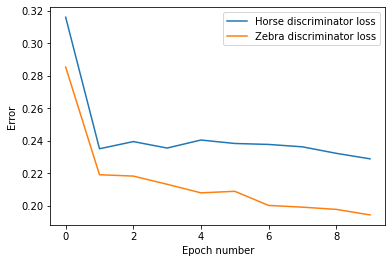

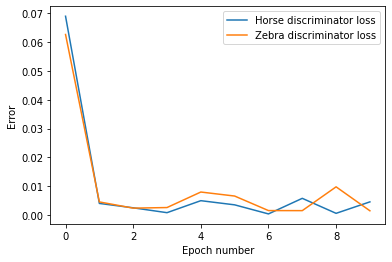

In [33]:
# Loss
plt.plot(range(10), out_dict['d_h_loss'])
plt.plot(range(10), out_dict['d_z_loss'])
plt.legend(('Horse discriminator loss', 'Zebra discriminator loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()
plt.plot(range(10), out_dict2['d_h_loss'])
plt.plot(range(10), out_dict2['d_z_loss'])
plt.legend(('Horse discriminator loss', 'Zebra discriminator loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()
plt.plot(range(10), out_dict3['d_h_loss'])
plt.plot(range(10), out_dict3['d_z_loss'])
plt.legend(('Horse discriminator loss', 'Zebra discriminator loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()

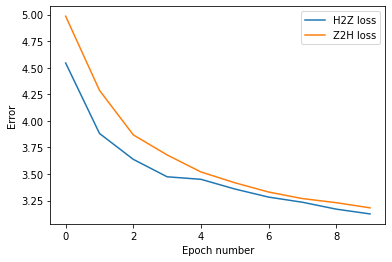

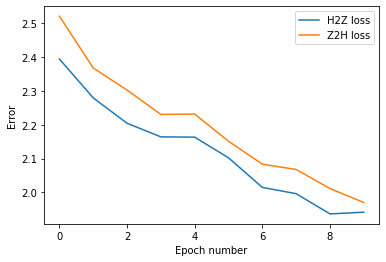

In [35]:
# Loss
plt.plot(range(10), out_dict['g_h2z_loss'])
plt.plot(range(10), out_dict['g_z2h_loss'])
plt.legend(('H2Z loss', 'Z2H loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()
plt.plot(range(10), out_dict2['g_h2z_loss'])
plt.plot(range(10), out_dict2['g_z2h_loss'])
plt.legend(('H2Z loss', 'Z2H loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()
plt.plot(range(10), out_dict3['g_h2z_loss'])
plt.plot(range(10), out_dict3['g_z2h_loss'])
plt.legend(('H2Z loss', 'Z2H loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()

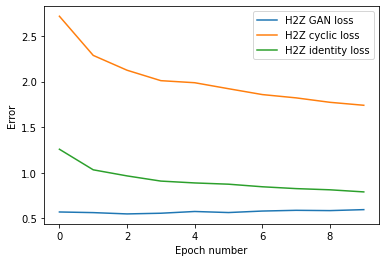

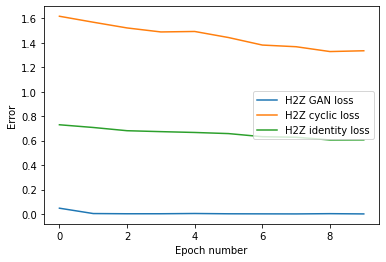

In [36]:
# Loss
plt.plot(range(10), out_dict['g_h2z_gan_true_loss'])
plt.plot(range(10), out_dict['g_h2z_cyclic_loss'])
plt.plot(range(10), out_dict['g_h2z_identity_loss'])
plt.legend(('H2Z GAN loss', 'H2Z cyclic loss', 'H2Z identity loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()
plt.plot(range(10), out_dict2['g_h2z_gan_true_loss'])
plt.plot(range(10), out_dict2['g_h2z_cyclic_loss'])
plt.plot(range(10), out_dict2['g_h2z_identity_loss'])
plt.legend(('H2Z GAN loss', 'H2Z cyclic loss', 'H2Z identity loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()
plt.plot(range(10), out_dict3['g_h2z_gan_true_loss'])
plt.plot(range(10), out_dict3['g_h2z_cyclic_loss'])
plt.plot(range(10), out_dict3['g_h2z_identity_loss'])
plt.legend(('H2Z GAN loss', 'H2Z cyclic loss', 'H2Z identity loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()

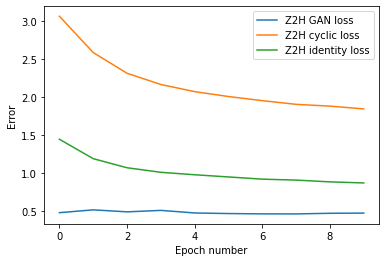

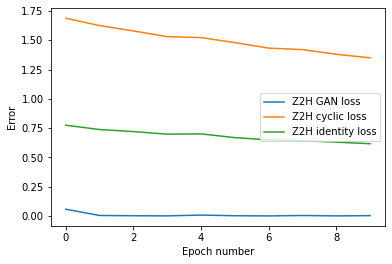

In [37]:
# Loss
plt.plot(range(10), out_dict['g_z2h_gan_true_loss'])
plt.plot(range(10), out_dict['g_z2h_cyclic_loss'])
plt.plot(range(10), out_dict['g_z2h_identity_loss'])
plt.legend(('Z2H GAN loss', 'Z2H cyclic loss', 'Z2H identity loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()
plt.plot(range(10), out_dict2['g_z2h_gan_true_loss'])
plt.plot(range(10), out_dict2['g_z2h_cyclic_loss'])
plt.plot(range(10), out_dict2['g_z2h_identity_loss'])
plt.legend(('Z2H GAN loss', 'Z2H cyclic loss', 'Z2H identity loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()
plt.plot(range(10), out_dict3['g_z2h_gan_true_loss'])
plt.plot(range(10), out_dict3['g_z2h_cyclic_loss'])
plt.plot(range(10), out_dict3['g_z2h_identity_loss'])
plt.legend(('Z2H GAN loss', 'Z2H cyclic loss', 'Z2H identity loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()

In [26]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [27]:
import torchvision.models as models
model_inception = models.inception_v3(pretrained=True)
model_inception.fc = Identity()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [28]:
model_inception.to(device)
model_inception.eval();

In [29]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [30]:
hookF = Hook(model_inception.fc)

In [31]:
from scipy.linalg import sqrtm

def calculate_fid(real, fake):

    real = np.array(real)
    fake = np.array(fake)
    mu1 = real.mean(axis=0)
    sigma1 = np.cov(real, rowvar=False)
    mu2 = fake.mean(axis=0)
    sigma2 = np.cov(fake, rowvar=False)
    
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
 
	# calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
 
	# check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

	# calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [32]:
out_real_h = []
out_fake_h = []
out_real_z = []
out_fake_z = []
for minibatch_no, (horse, zebra) in tqdm(enumerate(test_loader), total=len(test_loader)):
    # horse, zebra = next(iter(test_loader_i))
    horse = horse.to(device)
    zebra = zebra.to(device)

    # Create fake images through generators
    z_fake = g_h2z(horse) # horse to fake zebra
    h_fake = g_z2h(zebra) # zebra to fake horse

    # Pass images through the model
    with torch.no_grad():
        model_inception(horse)
        out_real_h.append(hookF.output.cpu().squeeze().numpy())
        model_inception(h_fake)
        out_fake_h.append(hookF.output.cpu().squeeze().numpy())
        model_inception(zebra)
        out_real_z.append(hookF.output.cpu().squeeze().numpy())
        model_inception(z_fake)
        out_fake_z.append(hookF.output.cpu().squeeze().numpy())

In [33]:
calculate_fid(out_real_h, out_fake_h)

372.46632540998087

In [34]:
calculate_fid(out_real_z, out_fake_z)

164.0814923922286